In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from datetime import datetime

In [2]:
class Config:
    DATA_PATH = r"/kaggle/input/tabular-dataset-ready-for-malicious-url-detection/train_dataset.csv"
    BATCH_SIZE = 512  # Reduced for better generalization
    NUM_EPOCHS = 150  # Increased epochs
    LEARNING_RATE = 0.0005  # Reduced initial learning rate
    WEIGHT_DECAY = 0.001  # Reduced weight decay
    PATIENCE = 20  # More aggressive early stopping
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    USE_CLASS_WEIGHTS = True  # Enable class weights for better handling of imbalanced data
    USE_SCALING = True  # Add feature scaling
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    GRADIENT_CLIP = 1.0  # Add gradient clipping
    WARMUP_EPOCHS = 5  # Learning rate warmup

config = Config()

In [3]:
df = pd.read_csv(config.DATA_PATH)
display(df.head())

,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,irs-profilepaymentservice.com/home,1,phishtank,0,0,0,0,0,0,34,...,0,0,0,0,3,com,0,17,0,0
1,cpuggsukabumi.id,0,majestic_million,0,0,0,0,0,0,16,...,0,0,0,0,2,id,1,10,0,0
2,members.tripod.com/~don_rc/ring.htm,0,data_clean_test_mendel,0,0,0,0,0,0,35,...,0,0,0,0,3,com,0,2,7,0
3,optuswebmailadminprovider.weebly.com/,1,phishtank,0,0,0,1,0,0,37,...,0,0,0,0,3,com,0,3,25,0
4,topoz.com.pl,0,dmoz_harvard,0,0,0,0,0,0,12,...,0,0,0,0,6,com.pl,0,3,0,0


In [4]:
df.columns

Index(['url', 'label', 'source', 'url_has_login', 'url_has_client',
       'url_has_server', 'url_has_admin', 'url_has_ip', 'url_isshorted',
       'url_len', 'url_entropy', 'url_hamming_1', 'url_hamming_00',
       'url_hamming_10', 'url_hamming_01', 'url_hamming_11', 'url_2bentropy',
       'url_3bentropy', 'url_count_dot', 'url_count_https', 'url_count_http',
       'url_count_perc', 'url_count_hyphen', 'url_count_www',
       'url_count_atrate', 'url_count_hash', 'url_count_semicolon',
       'url_count_underscore', 'url_count_ques', 'url_count_equal',
       'url_count_amp', 'url_count_letter', 'url_count_digit',
       'url_count_sensitive_financial_words', 'url_count_sensitive_words',
       'url_nunique_chars_ratio', 'path_len', 'path_count_no_of_dir',
       'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent',
       'path_has_any_sensitive_words', 'path_count_lower', 'path_count_upper',
       'path_count_nonascii', 'path_has_singlechardir', 'path_has_upperdir'

In [5]:
df['label'].value_counts()

label
0    5283175
1    1445673
Name: count, dtype: int64

In [6]:
X = df.drop(columns=['label', 'url', 'source', 'tld'])
y = df['label']

In [7]:
X.columns

Index(['url_has_login', 'url_has_client', 'url_has_server', 'url_has_admin',
       'url_has_ip', 'url_isshorted', 'url_len', 'url_entropy',
       'url_hamming_1', 'url_hamming_00', 'url_hamming_10', 'url_hamming_01',
       'url_hamming_11', 'url_2bentropy', 'url_3bentropy', 'url_count_dot',
       'url_count_https', 'url_count_http', 'url_count_perc',
       'url_count_hyphen', 'url_count_www', 'url_count_atrate',
       'url_count_hash', 'url_count_semicolon', 'url_count_underscore',
       'url_count_ques', 'url_count_equal', 'url_count_amp',
       'url_count_letter', 'url_count_digit',
       'url_count_sensitive_financial_words', 'url_count_sensitive_words',
       'url_nunique_chars_ratio', 'path_len', 'path_count_no_of_dir',
       'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent',
       'path_has_any_sensitive_words', 'path_count_lower', 'path_count_upper',
       'path_count_nonascii', 'path_has_singlechardir', 'path_has_upperdir',
       'query_len', 'que

In [8]:
if config.USE_CLASS_WEIGHTS:
    X_balanced = X
    y_balanced = y

    class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
    print(f"\nComputed class weights: {class_weights}")
    print(f"Class distribution: {np.bincount(y_balanced)}")
else:
    df_combined = pd.concat([X, y.rename('target')], axis=1)

    classes = np.unique(y)
    class_dfs = [df_combined[df_combined.target == c] for c in classes]

    min_samples = min(len(df) for df in class_dfs)
    print(f"\nOriginal class sizes: {[len(df) for df in class_dfs]}")

    downsampled_dfs = [
        resample(df, replace=False, n_samples=min_samples, random_state=42)
        for df in class_dfs
    ]

    df_balanced = pd.concat(downsampled_dfs)

    X_balanced = df_balanced.drop(columns=['target'])
    y_balanced = df_balanced['target'].values

    print(f"\nBalanced class distribution: {np.bincount(y_balanced)}")


Computed class weights: [0.63681858 2.32723721]
Class distribution: [5283175 1445673]


In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=config.TEST_SIZE,
    random_state=42,
    stratify=y_balanced
)

val_size_adjusted = config.VAL_SIZE / (1 - config.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    random_state=42,
    stratify=y_temp
)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 4710192
Validation set size: 1009328
Test set size: 1009328


In [10]:
# feature scaling if enabled
if config.USE_SCALING:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("Feature scaling applied")
else:
    X_train_scaled = X_train.values
    X_val_scaled = X_val.values
    X_test_scaled = X_test.values
    scaler = None
    print("No feature scaling applied")

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train if isinstance(y_train, np.ndarray) else y_train.values, dtype=torch.int64)
y_val_tensor = torch.tensor(y_val if isinstance(y_val, np.ndarray) else y_val.values, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test if isinstance(y_test, np.ndarray) else y_test.values, dtype=torch.int64)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Feature scaling applied
Train batches: 9200
Validation batches: 1972
Test batches: 1972


In [11]:
class MaliciousURLDetector(nn.Module):
    def __init__(self, input_dim, hidden_dims=[768, 512, 256, 128], dropout_rate=0.4, use_batch_norm=True):
        super(MaliciousURLDetector, self).__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm

        self.feature_attention = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim // 2, input_dim),
            nn.Sigmoid()
        )

        prev_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layer_block = []
            layer_block.append(nn.Linear(prev_dim, hidden_dim))

            if use_batch_norm:
                layer_block.append(nn.BatchNorm1d(hidden_dim))

            layer_block.append(nn.ReLU())
            layer_block.append(nn.Dropout(dropout_rate))

            setattr(self, f'layer_{i}', nn.Sequential(*layer_block))

            if prev_dim == hidden_dim:
                setattr(self, f'residual_{i}', nn.Identity())
            else:
                setattr(self, f'residual_{i}', nn.Sequential(
                    nn.Linear(prev_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim) if use_batch_norm else nn.Identity()
                ))

            prev_dim = hidden_dim

        self.output_dropout = nn.Dropout(0.3)
        self.output_layer = nn.Linear(hidden_dims[-1], 2)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using **Xavier/Glorot** for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        attention_weights = self.feature_attention(x)
        x = x * attention_weights

        for i in range(len(self.hidden_dims)):
            layer = getattr(self, f'layer_{i}')
            residual = getattr(self, f'residual_{i}')

            identity = residual(x)
            out = layer(x)
            x = out + identity  # Residual

        x = self.output_dropout(x)
        x = self.output_layer(x)
        return x

In [12]:
device = torch.device(config.DEVICE)
device

device(type='cuda')

In [13]:
model = MaliciousURLDetector(input_dim=X_train_tensor.shape[1]).to(device)

In [14]:
def train_epoch(model, loader, criterion, optimizer, device, gradient_clip=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Apply gradient clipping
        if gradient_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = correct / total
    
    # F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            probs = F.softmax(outputs, dim=1)

            total_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = correct / total
    
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # ROC
    try:
        all_probs_array = np.array(all_probs)
        roc_auc = roc_auc_score(all_labels, all_probs_array[:, 1])
    except:
        roc_auc = 0.0
    
    return avg_loss, accuracy, f1, precision, recall, roc_auc

In [15]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y_balanced))

model = MaliciousURLDetector(input_dim=X_train_tensor.shape[1]).to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

if config.USE_CLASS_WEIGHTS:
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
    print(f"Using weighted CrossEntropyLoss with label smoothing")
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    print(f"Using standard CrossEntropyLoss with label smoothing")

optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

print(f"\nTraining on device: {config.DEVICE}")

Total parameters: 1,213,590
Trainable parameters: 1,213,590
Using weighted CrossEntropyLoss with label smoothing

Training on device: cuda


In [16]:
best_val_loss = float('inf')
best_val_acc = 0
best_val_f1 = 0
patience_counter = 0

train_losses = []
train_accs = []
train_f1s = []
val_losses = []
val_accs = []
val_f1s = []
val_precisions = []
val_recalls = []
val_roc_aucs = []

start_time = datetime.now()

print("Starting training...")
print("=" * 80)

for epoch in range(config.NUM_EPOCHS):
    if epoch < config.WARMUP_EPOCHS:
        warmup_lr = config.LEARNING_RATE * (epoch + 1) / config.WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr
    
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, config.DEVICE, 
        gradient_clip=config.GRADIENT_CLIP
    )
    
    val_loss, val_acc, val_f1, val_precision, val_recall, val_roc_auc = validate(
        model, val_loader, criterion, config.DEVICE
    )

    if epoch >= config.WARMUP_EPOCHS:
        scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_roc_aucs.append(val_roc_auc)

    if val_f1 > best_val_f1:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_f1 = val_f1
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_f1': train_f1,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_roc_auc': val_roc_auc,
        }, 'best_model.pth')
    else:
        patience_counter += 1

    if epoch % 5 == 0 or epoch < 10:
        print(f'Epoch [{epoch+1}/{config.NUM_EPOCHS}]')
        print(f'  Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}')
        print(f'  Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}')
        print(f'  Val   - Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | ROC-AUC: {val_roc_auc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f} | Patience: {patience_counter}/{config.PATIENCE}')
        print("-" * 80)

    if patience_counter >= config.PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print("=" * 80)
print("Training completed!")

Starting training...
Epoch [1/150]
  Train - Loss: 0.4828 | Acc: 0.8736 | F1: 0.8788
  Val   - Loss: 0.4657 | Acc: 0.8505 | F1: 0.8596
  Val   - Precision: 0.8871 | Recall: 0.8505 | ROC-AUC: 0.9355
  LR: 0.000100 | Patience: 0/20
--------------------------------------------------------------------------------
Epoch [2/150]
  Train - Loss: 0.4496 | Acc: 0.8987 | F1: 0.9015
  Val   - Loss: 0.4396 | Acc: 0.8983 | F1: 0.9015
  Val   - Precision: 0.9087 | Recall: 0.8983 | ROC-AUC: 0.9427
  LR: 0.000200 | Patience: 0/20
--------------------------------------------------------------------------------
Epoch [3/150]
  Train - Loss: 0.4423 | Acc: 0.9059 | F1: 0.9080
  Val   - Loss: 0.4349 | Acc: 0.9140 | F1: 0.9155
  Val   - Precision: 0.9182 | Recall: 0.9140 | ROC-AUC: 0.9451
  LR: 0.000300 | Patience: 0/20
--------------------------------------------------------------------------------
Epoch [4/150]
  Train - Loss: 0.4385 | Acc: 0.9098 | F1: 0.9116
  Val   - Loss: 0.4339 | Acc: 0.9174 | F1: 0.

In [18]:
training_time = datetime.now() - start_time
print(f"\nTraining completed in {training_time}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best validation F1 score: {best_val_f1:.4f}")

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best model metrics:")
print(f"  - Validation F1: {checkpoint['val_f1']:.4f}")
print(f"  - Validation Accuracy: {checkpoint['val_acc']:.4f}")
print(f"  - Validation Precision: {checkpoint['val_precision']:.4f}")
print(f"  - Validation Recall: {checkpoint['val_recall']:.4f}")
print(f"  - Validation ROC-AUC: {checkpoint['val_roc_auc']:.4f}")


Training completed in 3:19:17.886359
Best validation loss: 0.4151
Best validation accuracy: 0.9319
Best validation F1 score: 0.9324


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

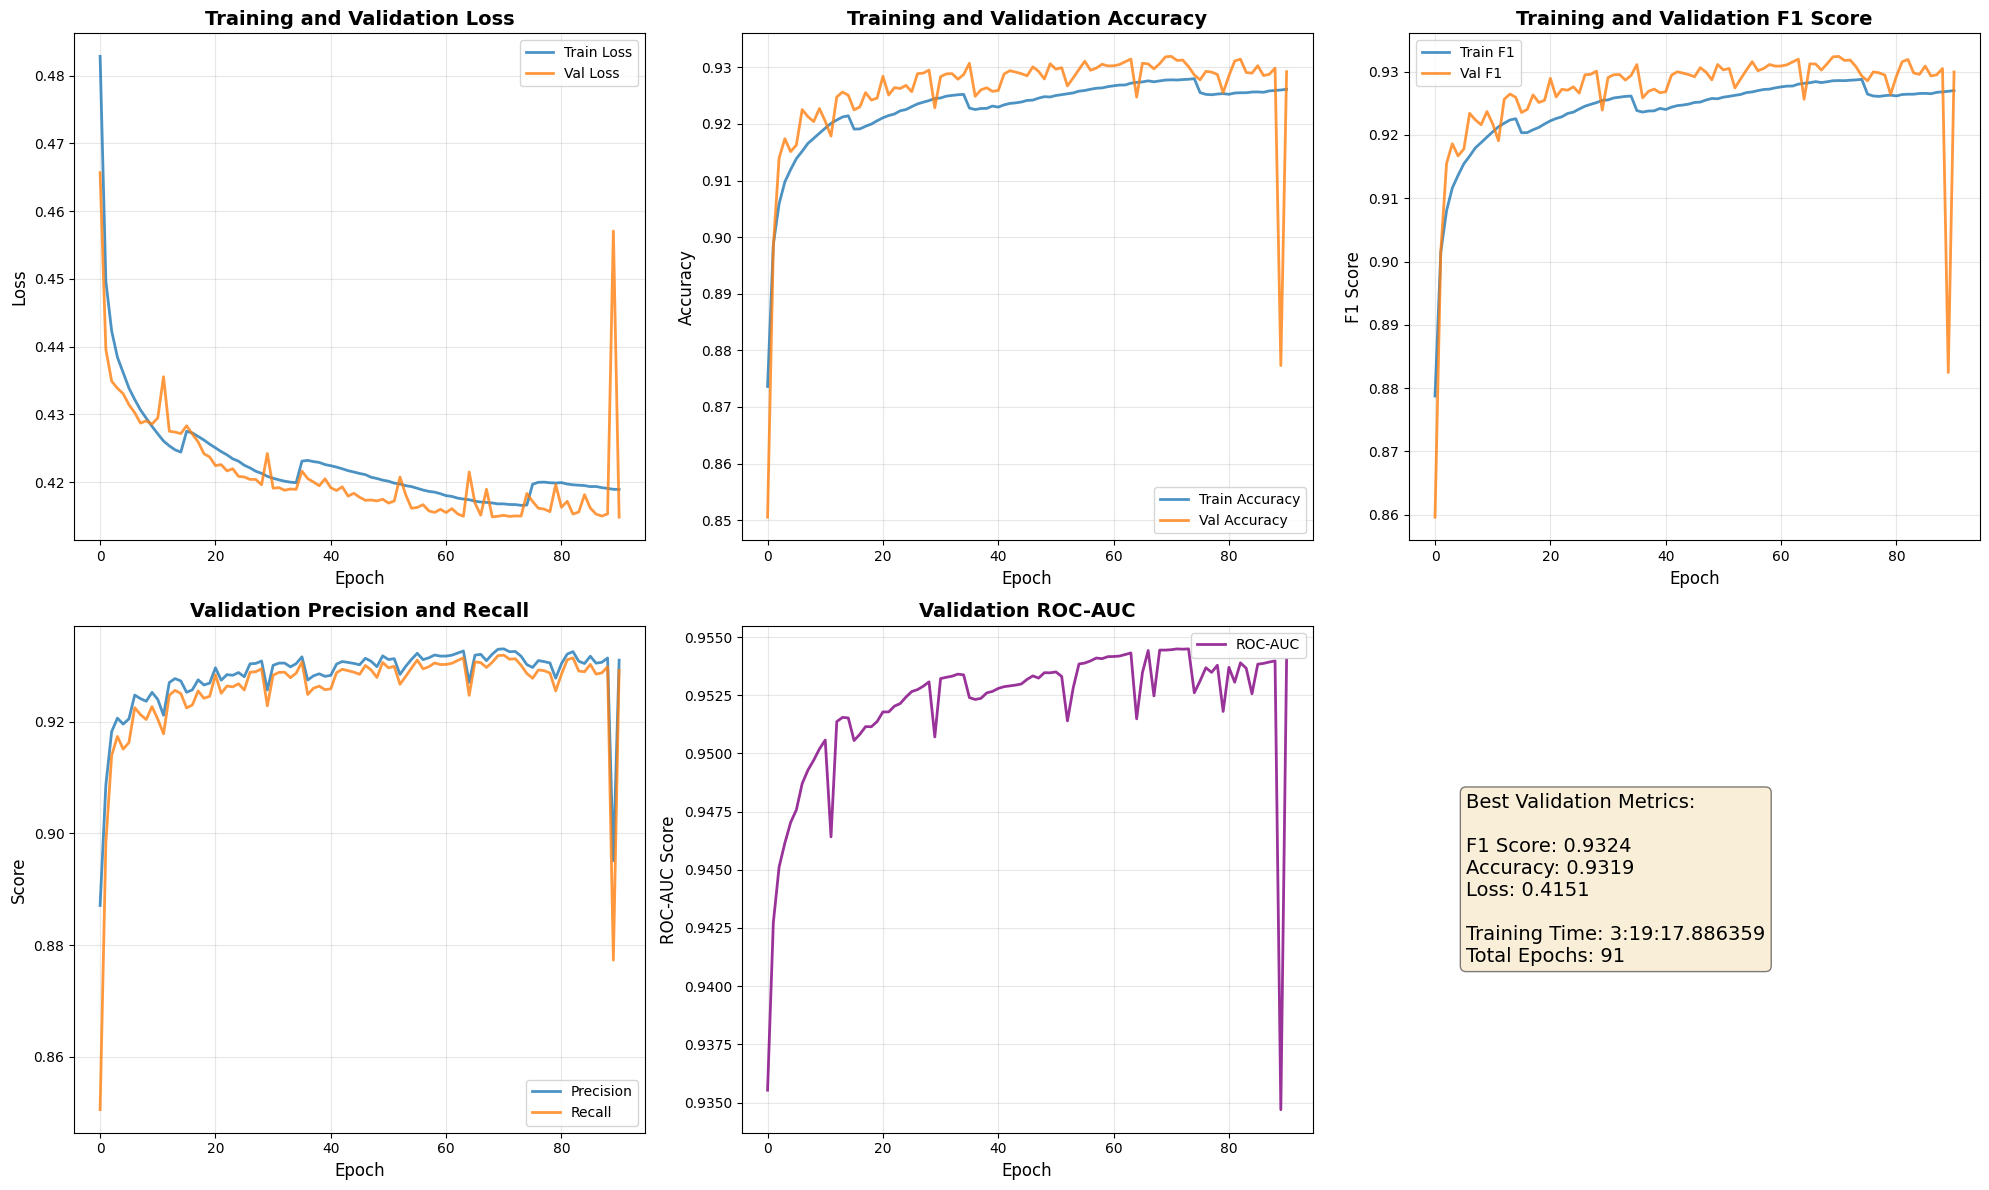

Training history plot saved as 'training_history_enhanced.png'


In [19]:
# Enhanced training visualization
plt.figure(figsize=(20, 12))

# Loss curves
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8, linewidth=2)
plt.plot(val_losses, label='Val Loss', alpha=0.8, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(2, 3, 2)
plt.plot(train_accs, label='Train Accuracy', alpha=0.8, linewidth=2)
plt.plot(val_accs, label='Val Accuracy', alpha=0.8, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# F1 Score curves
plt.subplot(2, 3, 3)
plt.plot(train_f1s, label='Train F1', alpha=0.8, linewidth=2)
plt.plot(val_f1s, label='Val F1', alpha=0.8, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Precision and Recall
plt.subplot(2, 3, 4)
plt.plot(val_precisions, label='Precision', alpha=0.8, linewidth=2)
plt.plot(val_recalls, label='Recall', alpha=0.8, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Validation Precision and Recall', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# ROC-AUC
plt.subplot(2, 3, 5)
plt.plot(val_roc_aucs, label='ROC-AUC', alpha=0.8, linewidth=2, color='purple')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Validation ROC-AUC', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Summary metrics
plt.subplot(2, 3, 6)
metrics_text = f"Best Validation Metrics:\n\n"
metrics_text += f"F1 Score: {best_val_f1:.4f}\n"
metrics_text += f"Accuracy: {best_val_acc:.4f}\n"
metrics_text += f"Loss: {best_val_loss:.4f}\n\n"
metrics_text += f"Training Time: {training_time}\n"
metrics_text += f"Total Epochs: {len(train_losses)}"
plt.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.axis('off')

plt.tight_layout()
plt.savefig('training_history_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history_enhanced.png'")

In [20]:
# Comprehensive test set evaluation
test_loss, test_acc, test_f1, test_precision, test_recall, test_roc_auc = validate(
    model, test_loader, criterion, config.DEVICE
)

print("\n" + "=" * 80)
print("TEST SET RESULTS")
print("=" * 80)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test ROC-AUC:   {test_roc_auc:.4f}")
print("=" * 80)

# Get predictions for detailed analysis
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(config.DEVICE)
        outputs = model(batch_X)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Print detailed classification report
print("\nDetailed Classification Report:")
print("-" * 80)
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malicious']))


TEST SET RESULTS
Test Loss:      0.4149
Test Accuracy:  0.9297
Test F1 Score:  0.9304
Test Precision: 0.9314
Test Recall:    0.9297
Test ROC-AUC:   0.9542

Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.96      0.95      0.95    792477
   Malicious       0.82      0.86      0.84    216851

    accuracy                           0.93   1009328
   macro avg       0.89      0.91      0.90   1009328
weighted avg       0.93      0.93      0.93   1009328



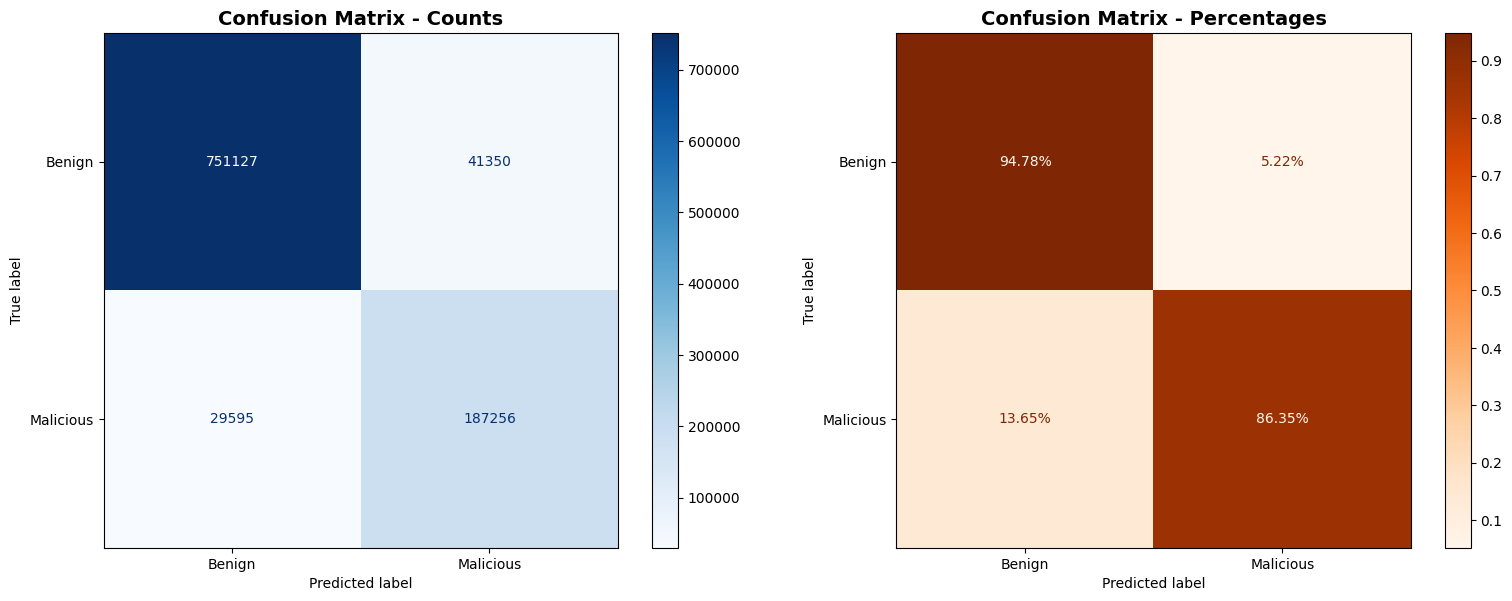

Enhanced confusion matrix saved as 'confusion_matrix_enhanced.png'


In [21]:
# Enhanced confusion matrix visualization
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix with counts
cm = confusion_matrix(all_labels, all_preds)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Counts', fontsize=14, fontweight='bold')

# Confusion matrix with percentages
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Benign', 'Malicious'])
disp2.plot(ax=axes[1], cmap='Oranges', values_format='.2%')
axes[1].set_title('Confusion Matrix - Percentages', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced confusion matrix saved as 'confusion_matrix_enhanced.png'")

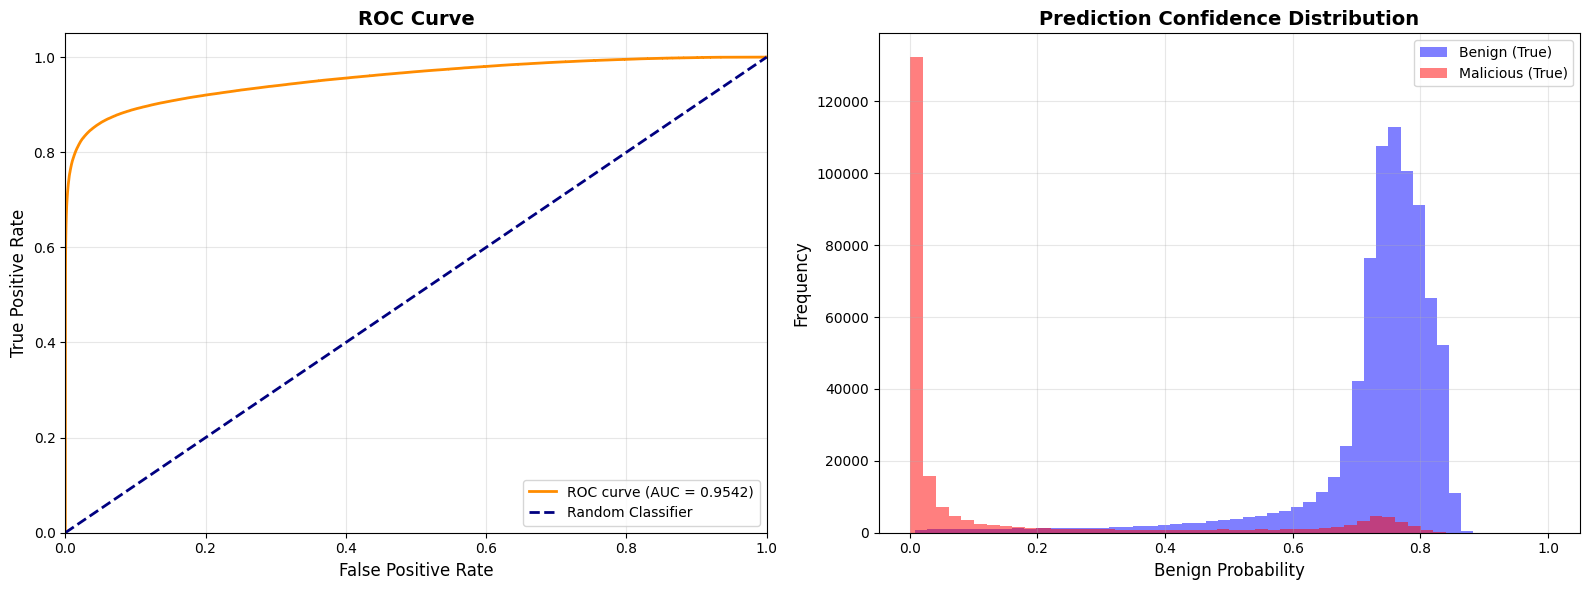

ROC curve and confidence distribution saved as 'roc_and_confidence.png'


In [22]:
# ROC Curve and additional visualizations
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(True, alpha=0.3)

# Prediction confidence distribution
axes[1].hist(all_probs[:, 0][all_labels == 0], bins=50, alpha=0.5, label='Benign (True)', color='blue')
axes[1].hist(all_probs[:, 0][all_labels == 1], bins=50, alpha=0.5, label='Malicious (True)', color='red')
axes[1].set_xlabel('Benign Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_and_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curve and confidence distribution saved as 'roc_and_confidence.png'")

In [23]:
def save_complete_model(model, config, feature_names, scaler=None, tld_encoder=None, save_dir='./model_artifacts'):
    import os
    os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Save model
    model_path = f'{save_dir}/model_{timestamp}.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.input_dim,
        'hidden_dims': model.hidden_dims,
        'dropout_rate': model.dropout_rate,
        'use_batch_norm': model.use_batch_norm,
    }, model_path)
    print(f"✓ Model saved to: {model_path}")

    # Save features
    feature_path = f'{save_dir}/features_{timestamp}.pkl'
    with open(feature_path, 'wb') as f:
        pickle.dump(feature_names, f)
    print(f"✓ Features saved to: {feature_path}")

    # Save config
    config_path = f'{save_dir}/config_{timestamp}.pkl'
    config_dict = {
        'BATCH_SIZE': config.BATCH_SIZE,
        'DEVICE': config.DEVICE,
        'USE_CLASS_WEIGHTS': config.USE_CLASS_WEIGHTS,
        'USE_SCALING': config.USE_SCALING,
    }
    with open(config_path, 'wb') as f:
        pickle.dump(config_dict, f)
    print(f"✓ Config saved to: {config_path}")

    # Save scaler if provided
    scaler_path = None
    if scaler is not None:
        try:
            scaler_path = f"{save_dir}/scaler_{timestamp}.pkl"
            joblib.dump(scaler, scaler_path)
            print(f"✓ Scaler saved to: {scaler_path}")
        except Exception as e:
            print(f"⚠ Could not save scaler: {e}")

    # Save TLD encoder if provided
    tld_path = None
    if tld_encoder is not None:
        try:
            tld_path = f"{save_dir}/tld_encoder_{timestamp}.pkl"
            joblib.dump(tld_encoder, tld_path)
            print(f"✓ TLD encoder saved to: {tld_path}")
        except Exception as e:
            print(f"⚠ Could not save TLD encoder: {e}")

    return model_path, feature_path, config_path, scaler_path, tld_path

In [24]:
feature_names = X.columns.tolist()

model_path, feature_path, config_path, scaler_path, tld_path = save_complete_model(
    model, config, feature_names, scaler=scaler
)
print('\nSaved artifacts:')
print('  model_path:', model_path)
print('  feature_path:', feature_path)
print('  config_path:', config_path)
if scaler_path:
    print('  scaler_path:', scaler_path)

✓ Model saved to: ./model_artifacts/model_20251023_003423.pth
✓ Features saved to: ./model_artifacts/features_20251023_003423.pkl
✓ Config saved to: ./model_artifacts/config_20251023_003423.pkl
✓ Scaler saved to: ./model_artifacts/scaler_20251023_003423.pkl

Saved artifacts:
  model_path: ./model_artifacts/model_20251023_003423.pth
  feature_path: ./model_artifacts/features_20251023_003423.pkl
  config_path: ./model_artifacts/config_20251023_003423.pkl
  scaler_path: ./model_artifacts/scaler_20251023_003423.pkl


In [25]:
def load_model_for_prediction(model_path, feature_path, config_path, scaler_path=None):
    # Load model
    checkpoint = torch.load(model_path, map_location='cpu')

    model = MaliciousURLDetector(
        input_dim=checkpoint['input_dim'],
        hidden_dims=checkpoint['hidden_dims'],
        dropout_rate=checkpoint['dropout_rate'],
        use_batch_norm=checkpoint['use_batch_norm']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load features
    with open(feature_path, 'rb') as f:
        feature_names = pickle.load(f)

    # Load config
    with open(config_path, 'rb') as f:
        config_dict = pickle.load(f)

    # Load scaler if provided
    scaler = None
    if scaler_path is not None:
        try:
            scaler = joblib.load(scaler_path)
            print("✓ Scaler loaded successfully")
        except Exception as e:
            print(f"⚠ Could not load scaler: {e}")

    print("✓ Model loaded successfully!")
    return model, scaler, feature_names, config_dict

In [26]:
def predict_urls(model, scaler, feature_names, new_data, device='cpu'):
    """
    Predict malicious URLs using the trained model
    
    Args:
        model: Trained PyTorch model
        scaler: Fitted StandardScaler (can be None if no scaling was used)
        feature_names: List of feature names
        new_data: DataFrame or array with features
        device: Device to run inference on
    
    Returns:
        predictions: Array of predicted classes (0=benign, 1=malicious)
        probabilities: Array of prediction probabilities
    """
    model.to(device)
    model.eval()

    # Handle DataFrame input
    if isinstance(new_data, pd.DataFrame):
        new_data = new_data[feature_names]
        new_data = new_data.values

    # Apply scaling if scaler is provided
    if scaler is not None:
        X_scaled = scaler.transform(new_data)
    else:
        X_scaled = new_data

    # Convert to tensor
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(X_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    return predictions.cpu().numpy(), probabilities.cpu().numpy()

In [27]:
# Test the prediction function
predictions, probabilities = predict_urls(
    model, scaler, feature_names, X_test, device=config.DEVICE
)

print(f"Predictions shape: {predictions.shape}")
print(f"Probabilities shape: {probabilities.shape}")
print(f"\nFirst 10 predictions: {predictions[:10]}")
print(f"First 10 probabilities (malicious class): {probabilities[:10, 1]}")

# Calculate accuracy on test set
accuracy = (predictions == y_test).mean()
print(f"\nTest accuracy using prediction function: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predictions shape: (1009328,)
Probabilities shape: (1009328, 2)

First 10 predictions: [1 1 0 0 0 0 0 0 0 0]
First 10 probabilities (malicious class): [0.9865095  0.9868194  0.21701467 0.23562019 0.22119181 0.23642671
 0.15921676 0.2712299  0.17014983 0.20468968]

Test accuracy using prediction function: 0.9297


In [28]:
# Test single sample prediction
single_sample = X_test.iloc[[0]]
pred, prob = predict_urls(model, scaler, feature_names, single_sample, device=config.DEVICE)

print(f"Sample URL Prediction:")
print(f"  Prediction: {'Malicious' if pred[0] == 1 else 'Benign'}")
print(f"  Confidence: {prob[0][pred[0]]:.4f}")
print(f"  Benign probability: {prob[0][0]:.4f}")
print(f"  Malicious probability: {prob[0][1]:.4f}")
print(f"  Actual label: {'Malicious' if y_test[0] == 1 else 'Benign'}")

Sample URL Prediction:
  Prediction: Malicious
  Confidence: 0.9865
  Benign probability: 0.0135
  Malicious probability: 0.9865


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


KeyError: 0